### David Fleming

---

Aurora detection feasibility study.

August 2016

In [1]:
#Imports
%matplotlib inline

from __future__ import print_function, division

#Imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize 

#Typical plot parameters that make for pretty plots
mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['font.size'] = 20.0

## for Palatino and other serif fonts use:
mpl.rc('font',**{'family':'serif','serif':['Computer Modern']})
mpl.rc('text', usetex=True)

** Define constants **

In [2]:
# Constants all in cgs
RSUN = 6.955e10 # radius of sun
REARTH = 6.3674447e8 # radius of earth
AUCM = 1.496e13 # cm per AU
ANGCM = 1e-8 # cm per Angstrom
PCCM = 3.086e18 # cm per parsec 

# Physical constastns
h = 6.6260755e-27 # Planck constant
c = 3.0e10 # Speed of light
k = 1.380658e-16 # Boltzman const

# Prox consts
TSTAR = 3050.0 # Proxima Centauri's effective temperature (K)
TP = 288.0 # Planet's effective temperature if Earth-like
DIST = 3.991e18# Distance to proxima cen

RSTAR = 0.14*RSUN
RP = 1.07*REARTH # Prox Cen b radius if terrestrial
AP = 0.0485*AUCM

# Auroral stengths
RUNIT = 1.0e6 # 1 Rayleigh == 1.0e6 photons/(cm^2 s)
EARTH_OIG = 1.0e6*RUNIT # Class 4 -> KiloRayleigh signal

# How does the blackbody flux compare to actual VPL (Meadows et al. 2016) Proxima Centauri Spectra?

---

Due to TiO absorption bands, we might actually get an additional contrast boost!

In [3]:
# Load in the VPL data

# Note: Wavelength in microns, Flux in W/m^2/micron
spec_path = "../airglow/fits/ProxCenHubbleSpectrum.txt"
spec = np.genfromtxt(spec_path,skip_header=25)

# Covert from 1 AU normalization to Prox Cen Distance
spec[:,1] *= (AUCM/DIST)**2

In [4]:
# Takes cgs, outputs blackbody in cgs
def planck(T,lam):
    return (2.0*h*c*c/np.power(lam,5.))/(np.exp(h*c/(lam*k*T)) - 1.0)

In [5]:
# Now create a blackbody function
T = 3100 # Best fit stellar temperature

# Conv goes from cgs -> W/m^2/micron and scale from 1 AU -> distance
# Also do intensity -> flux where F = PI * B * (R/d)^2
conv = np.pi*1.0e-7*100*100*((RSTAR/DIST)**2)*1.0e-4

bb = planck(T,spec[:,0]*1.0e-4)*conv

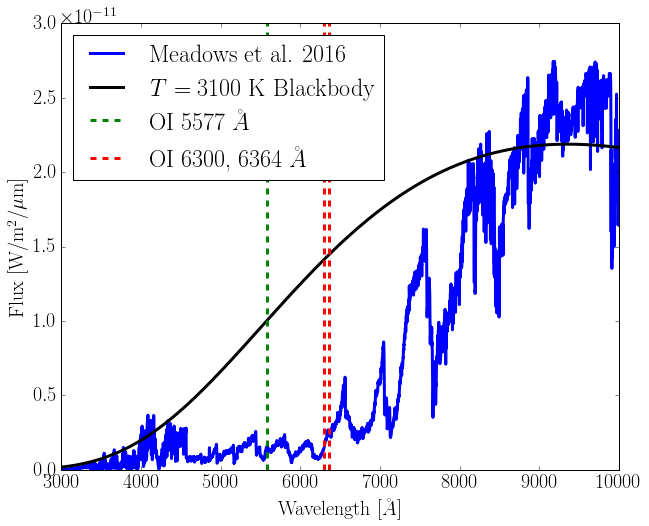

In [6]:
fig, ax = plt.subplots()

# Ignore that huge initial jump
cut = 3

# Actual Spectrum
ax.plot(spec[cut:,0]*1.0e4,spec[cut:,1],lw=3,label="Meadows et al. 2016")

# Best fit blackbody
ax.plot(spec[cut:,0]*1.0e4, bb[cut:], lw=3, color="black", label=r"$T = 3100$ K Blackbody")

# Lines of interest
ax.axvline(x=5577,lw=3,ls="--",color="green",label=r"OI 5577 $\AA$")
ax.axvline(x=6300,lw=3,ls="--",color="red",label=r"OI 6300, 6364 $\AA$")
ax.axvline(x=6364,lw=3,ls="--",color="red")

# Format
ax.set_xlim(0.3*1.0e4,1*1.0e4)
ax.set_ylim(0,3.0e-11)
leg = ax.legend(loc="upper left")

ax.set_xlabel(r"Wavelength [$\AA$]")
ax.set_ylabel(r"Flux [W/m$^2$/$\mu$m]")

#fig.savefig("/Users/dflemin3/Desktop/prox_cen_spec.pdf")

# What about reflected light star-planet contrast ratios?

---

For reflected light at some phase $\alpha$ where 0 is the full phase,

$$
F_p = F_s \frac{R^2_p}{a^2} A \Psi (\alpha)
$$

where $R_p$ is the planet radius and $a$ is the orbital semimajor axis (see Hu et al. 2015).

Note for flux from a body,

$$
F = \pi B \left( \frac{R}{d} \right)^2
$$

where B is the blackbody intentsity (wavelength dependent in general), R is the radius of the emitting body and d is the distance from the body to the observer.

### Parameter definitions

---

Note: $\alpha = 0$ corresponds to the full planet phase! 

### Define phase function functions

In [7]:
def phaseAngleLongLat(t1,t2,p1,p2):
    """
    Calculate the phase angle (alpha) with respect to the longitude and latitude 
    of the sub-stellar and sub-observer point.  All angles input in degrees.

    Parameters
    ----------
    
        t1 : float
            Sub-observer latitude (radians)
        t2 : float
            Sub-stellar latitude (radians)
        p1 : float 
            Sub-observer longitude (radians)
        p2 : float 
            Sub-stellar longitude (radians)
    
    Returns
    -------
    alpha : float
        The planet phase angle (radians)
    """
    
    # Convert from deg -> rad
    conv = np.pi / 180.0
    
    return np.arccos(np.sin(t1*conv)*np.sin(t2*conv) + np.cos(t1*conv)*np.cos(t2*conv)*np.cos((p1-p2)*conv))/conv

def phaseAngleKep(nu, inc, varpi=0.0):
    """
    Compute the phase angle alpha given the planet's true anomaly, inclination and
    the longitude of periastron.  All input angle assumed to be degrees.
    
    Parameters
    ----------
    nu : float
        True anomaly
    inc : float
        Inclination
    varpi : float (optional)
        Longitude of periastron
        
    Returns
    -------
    alpha : float
        The planet phase angle (deg)
    """
    
    conv = 180.0 / np.pi
    
    # Temp vars
    eta = (nu + varpi)/conv
    
    return np.arccos(np.sin(eta)*np.sin(inc/conv))*conv
    
def lambertPhaseFunction(alpha):
    """
    Calculate the Lambertian Phase Function from the phase angle.
    Parameters
    ----------
        alpha : float
            Planet phase angle (degrees)
    
    Returns
    -------
        Psi : float
            The Lambertian phase function
    """
    conv = np.pi / 180.
    return np.fabs((np.sin(alpha*conv) + (np.pi - alpha*conv) * np.cos(alpha*conv)) / np.pi)
    
def contrast_alpha(alpha,A,f=1.0):
    """
    Star-planet contrast
    """
    psi = lambertPhaseFunction(alpha)
    return psi*A*f

def contrast_nu(nu,A,inc=0.0,varpi=0.0,f=1.0):
    """
    Star-planet contrast
    """
    
    conv = 180.0 / np.pi
    
    eta = nu + varpi
        
    alpha = phaseAngleKep(nu, inc, varpi)
    
    psi = lambertPhaseFunction(alpha)
    
    return psi*A*f

### Define Planet, Star, System objects for easy computations

---

All units assumed CGS!

In [8]:
class Planet(object):
    def __init__(self,A=0.3,Rp=RP,a=AP,OIG=126.6*EARTH_OIG,aurora_area=0.1,name="Proxima Centauri b"):
        # Assumed circular orbit
        self.name = name # Planet's name
        self.A = A # Geometric albedo (assumed grey)
        self.Rp = Rp # Radius of planet
        self.a = AP # Orbital semimajor axis
        self.aurora_area = aurora_area # Area of planet that emits aurora
        self.OIG = OIG # Aurora strength relative to Earth's at OI 5577 line
        
    def __repr__(self):
        return ("%s: Geometric Albedo: %.2lf. Radius (REARTH): %.2lf. Semimajor Axis (AU): %.2lf"
             % (self.name, self.A, self.Rp/REARTH, self.a/AUCM))

# end class
    
class Star(object):
    def __init__(self,Teff=3050.,Rs=RSTAR,d=DIST,name="Proxima Centauri"):
        # Init with Prox Cen's params + EV Lac's magneto-stuff (Cohen et al. 2014)
        self.name = name # Star's name
        self.Teff = Teff # Stellar effective temperature
        self.Rs = Rs # Stellar Radius
        self.d = d # Earth - star distance
        
    def __repr__(self):
        return ("%s: Teff (k): %.2lf. Radius (RSUN): %.2lf.  Earth-Star Distance (PC): %.2lf"
             % (self.name, self.Teff, self.Rs/RSUN, self.d/PCCM))

    def flux(self,lam_0,delta_lam):
        # Photon flux from star at lam_0 in delta_lam window (assumed const in window):
        # F = PI * B * (r/d)^2
        return planck(self.Teff,lam_0)*np.pi*np.power(self.Rs/self.d,2)*lam_0*delta_lam/(h*c)

#end class
        
class System(object):
    # Defaults to Proxima Centauri
    def __init__(self,star=Star(),planet=Planet()):
        self.planet = planet
        self.star = star
    
    # Star - Planet caused fluxes
    
    def contrast_ratio(self,alpha=0.0):
        # Star - Planet reflected light contrast ratio as function of phase
        return self.planet.A*lambertPhaseFunction(alpha)*np.power(self.planet.Rp/self.planet.a,2.)
    
    def ref_phot_flux(self,alpha,lam_0,delta_lam):
        # Given phase (alpha), central wavelength (lam_0) and small bandwitdh (delta_lam),
        # compute the planet's reflected flux in photons/(cm^2 s)
        tmp = np.pi * self.planet.A * lambertPhaseFunction(alpha)
        tmp *= np.power(self.star.Rs/self.planet.a,2.) * np.power(self.planet.Rp/self.star.d,2.)
        return tmp * planck(self.star.Teff,lam_0) * lam_0  * delta_lam / (h*c)
    
    def aurora_phot_flux(self,aurora):
        # Return auroral photon flux in photons /(cm^2 s)
        return (2.0*np.pi*self.planet.Rp**2)*aurora*self.planet.aurora_area/(4.0*np.pi*self.star.d**2)
    
    def __repr__(self):
        return "Star: " + self.star.__repr__() + "\nPlanet: " + self.planet.__repr__()

# end class
    
class Telescope(object):
    def __init__(self,D=10.0,eps=0.1):
        self.D = D # Telescope diameter in m
        self.eps = eps # Net telescope efficiency (throughput)
        
    def __repr__(self):
        return "Diameter (m): %.2lf. Efficiency: %.2lf." % (self.D, self.eps)
        
    def photons(self,flux,time):
        # Compute photons given a incident flux (photons/(cm^2 * s)) and
        # an efficiency eps integrate time in seconds
        return self.eps * flux * time * np.pi * np.power(self.D*100./2.,2.)
    
# end class

## Plots and Analysis

** Does my nu -> alpha transformation work? **

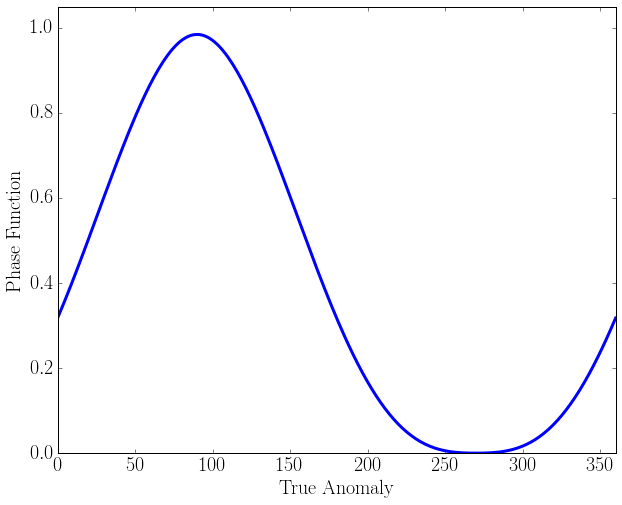

In [9]:
fig, ax = plt.subplots()

nu_grid = np.linspace(0,360.,250)

inc = 80
varpi = 0

alpha = phaseAngleKep(nu_grid, inc, varpi)
psi = lambertPhaseFunction(alpha)

ax.plot(nu_grid,psi,lw=3)

ax.set_xlim(0,360)
ax.set_ylim(0,1.05)

ax.set_xlabel(r"True Anomaly")
ax.set_ylabel("Phase Function")

### Albedo vs alpha

In [10]:
num = 100

alpha = np.linspace(0,360.0,num)
psi = lambertPhaseFunction(alpha)
f = 1.0

A = np.linspace(0.05,0.5,num)

ALPHA, A = np.meshgrid(alpha, A) # grid of point
Z = contrast_alpha(ALPHA, A) # evaluation of the function on the grid

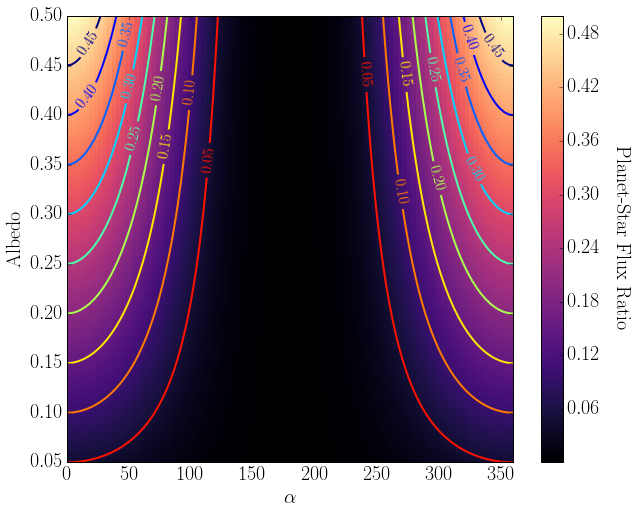

In [11]:
fig, ax = plt.subplots()


extent = [alpha.min(),alpha.max(),A.min(),A.max()]

im = ax.imshow(Z,cmap="magma",extent=extent,aspect="auto",
              origin="lower",interpolation="nearest") # drawing the function

# Plot contours on top
cset = ax.contour(Z, np.arange(0, 0.5, 0.05), linewidths=2,
                   cmap="jet_r",
                   extent=extent)
ax.clabel(cset, inline=True, fmt='%1.2f', fontsize=15)

# Format plot
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("Albedo")

cbar = fig.colorbar(im) 
cbar.ax.set_ylabel('Planet-Star Flux Ratio', rotation=270, labelpad=30)

### Albedo vs orbital true anomaly for an inclined orbit

In [12]:
inc = 80.0 # inclination in degrees where 90 deg == edge-on
varpi = 90.0

num = 100

# true anomaly grid
nu = np.linspace(0.,360.0,num)

# Entire flare hits planet
f = 1.0

# Albedo grid
A = np.linspace(0.05,0.5,num)

ALPHA, A = np.meshgrid(nu, A) # grid of point
Z = contrast_nu(nu, A, inc, varpi=varpi, f=f) # evaluation of the function on the grid

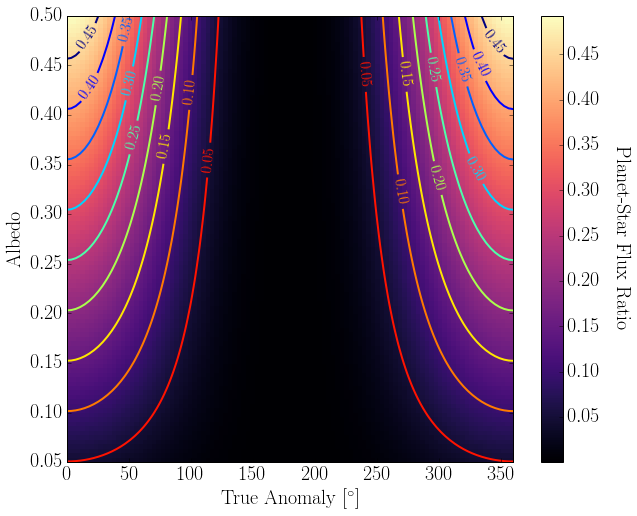

In [13]:
fig, ax = plt.subplots()

extent = [nu.min(),nu.max(),A.min(),A.max()]

im = ax.imshow(Z,cmap="magma",extent=extent,aspect="auto",
              origin="lower",interpolation="nearest") # drawing the function

# Plot contours on top
cset = ax.contour(Z, np.arange(0, 0.5, 0.05), linewidths=2,
                   cmap="jet_r",
                   extent=extent)
ax.clabel(cset, inline=True, fmt='%1.2f', fontsize=15)

# Format plot
ax.set_xlabel(r"True Anomaly [$^{\circ}$]")
ax.set_ylabel("Albedo")

cbar = fig.colorbar(im) 
cbar.ax.set_ylabel('Planet-Star Flux Ratio', rotation=270, labelpad=30)

### Model: Star - Planet flux ratio

From Robinson et al. 2016:

$$
\frac{F_{p,\lambda}}{F_{p,\lambda}} = A \Phi(\alpha) \left( \frac{R_p}{a} \right)^2
$$

and

$$
F_{p,\lambda} = \pi A \Phi(\alpha) B_{\lambda}(T_{eff}) \left( \frac{R_s}{a} \right)^2 \left( \frac{R_p}{d} \right)^2
$$

** Inits, examine properties **

In [14]:
# Init the system and the telescope you'll observe with
proxcen = System()
telescope = Telescope()

In [15]:
proxcen

Star: Proxima Centauri: Teff (k): 3050.00. Radius (RSUN): 0.14.  Earth-Star Distance (PC): 1.29
Planet: Proxima Centauri b: Geometric Albedo: 0.30. Radius (REARTH): 1.07. Semimajor Axis (AU): 0.05

In [16]:
telescope

Diameter (m): 10.00. Efficiency: 0.10.

** Plot Contrast Ratio as a function of Phase Angle **

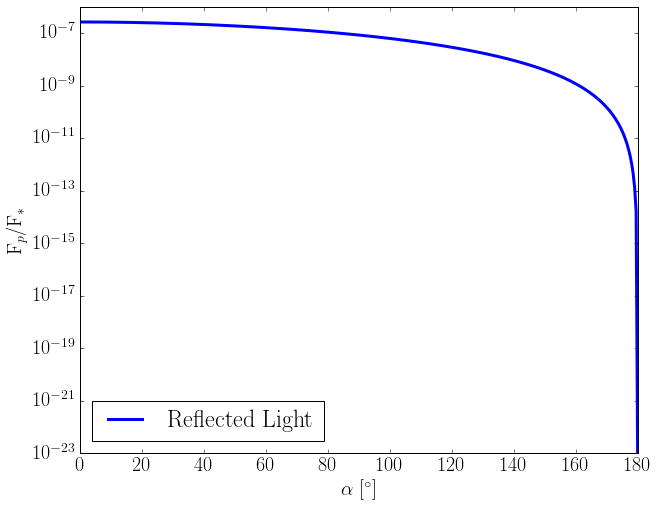

In [17]:
fig, ax = plt.subplots()

al = np.linspace(0,180,380)

ax.plot(al,proxcen.contrast_ratio(al),lw=3,label="Reflected Light")

# Format
ax.set_yscale("log")
ax.set_xlabel(r"$\alpha$ [$^{\circ}$]")
ax.set_ylabel(r"F$_p$/F$_*$")
ax.legend(loc="lower left")

In [18]:
# OI green (5577) auroral line
lam_OI = 5577.0 * ANGCM
dl = 0.1*ANGCM

b_ref_flux = proxcen.ref_phot_flux(0.0,lam_0=lam_OI,delta_lam=dl)
aurora_flux = proxcen.aurora_phot_flux(proxcen.planet.OIG)
star_flux = proxcen.star.flux(lam_OI,dl)

** What do the various contrast ratios look like? **

In [19]:
num = 100

# true anomaly grid
alpha = np.linspace(0.,160.0,num)

# Albedo grid
A = np.linspace(0.05,0.5,num)

ALPHA, A = np.meshgrid(alpha, A) # grid of point
Z = proxcen.contrast_ratio(ALPHA) # evaluation of the function on the grid

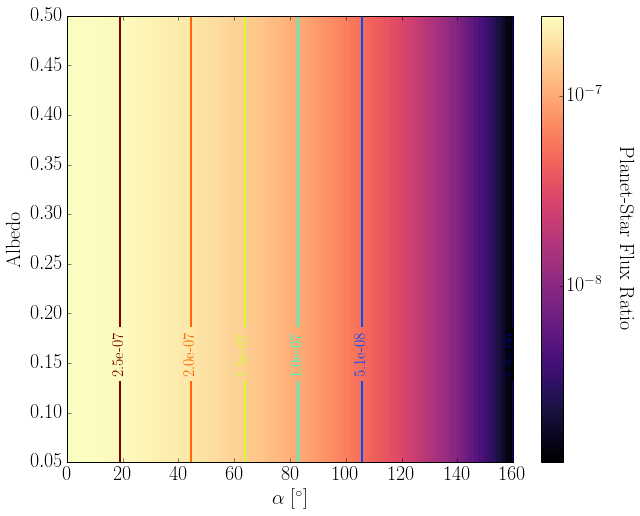

In [20]:
fig, ax = plt.subplots()

extent = [alpha.min(),alpha.max(),A.min(),A.max()]

im = ax.imshow(Z,cmap="magma",extent=extent,aspect="auto",
              origin="lower",interpolation="nearest",
              norm=mpl.colors.LogNorm()) # drawing the function

# Plot contours on top
cset = ax.contour(Z, np.arange(Z.min(), Z.max(), 5.0e-8), linewidths=2,
                   cmap="jet",
                   extent=extent)
ax.clabel(cset, inline=True, fmt='%.1e', fontsize=15)

# Format plot
ax.set_xlabel(r"$\alpha$ [$^{\circ}$]")
ax.set_ylabel("Albedo")

cbar = fig.colorbar(im) 
cbar.ax.set_ylabel('Planet-Star Flux Ratio', rotation=270, labelpad=30)

In [21]:
b_ref_flux/star_flux

2.6452852456080124e-07

In [22]:
aurora_flux/b_ref_flux

28.509351810696884

In [23]:
telescope.photons(aurora_flux,60)

0.86931926742251475

In [24]:
aurora_flux/star_flux

7.5415367706684537e-06

# How strong is Proxima b's Aurora relative to Earth's?

---

** Try Cohen et al 2016 Magnetic Fields Around M Dwarfs **

Assumes stellar/Interplanetary magnetic field for EV Lac

In [25]:
# For Sub-Alfvenic planet B
n_e = 433. # cm^-3
T_p = 3.42e5 # K
T_e = T_p/3. # K where T_p/T_e ~ 3 in slow solar wind
vel = [-630.,-1.,30.] # km/s
B_field = [-804.,-173.,63.] # nT, B = [B_x,B_y,B_z]
B_mag = np.sqrt(np.dot(B_field,B_field))
R_mag = 0.73*5 # Magnetopause radius in Earth Units

# Solar Quantities, same units but from Wang et al 2014
n_sol = 5.
Tp_sol = 1.0e4
Te_sol = Tp_sol/3.
vel_sol = [-400.,0.,0.]
B_sol = [0.,0.,-5.] 

In [26]:
def E_aurora(n,vel,B):
    """
    Auroral energy from Wang et al 2014.
    
    Parameters
    ----------
    n : float
        Solar wind number density [cm^-3]
    vel : array
        Cartesian components of solar wind at planet
    B : array
        Cartesian components of magnetic field at planet
        
    Returns
    -------
    Esw : float
        Energy of solar wind injected into aurora -> aurora power
    """
    
    A_aur = 0.36 # Fraction of stellar wind energy fed into aurora from Matt Tilley
    
    # Compute intermediate quantities (see Wang et al. 2014)
    theta = np.arctan2(B[1],B[2]) # IMF Clock angle
    Bt = np.sqrt(B[1]**2 + B[2]**2) # Transverse magnetic field
    v = np.sqrt(np.dot(vel,vel)) # Solar wind velocity
    
    # Convert theta range to [0,2pi)
    while theta < 0:
        theta += 2.0*np.pi
    while theta > 2.0*np.pi:
        theta -= 2.0*np.pi
    
    # For simplicity, assume same clock angle
    theta = 0.0
    
    # Returns in W
    return A_aur*3.78e7*np.power(n,0.24)*np.power(v,1.47)*np.power(Bt,0.86)*(np.power(np.sin(theta/2.),2.7)+0.25)

In [27]:
# Estimate auroral power of Prox b to Earth using EV Lac conditions
Proxb = E_aurora(n_e,vel,B_field)/E_aurora(n_sol,vel_sol,B_sol)
print("Aurora on Proxb are about %.2lf times stronger than on Earth." % Proxb)

Aurora on Proxb are about 126.65 times stronger than on Earth.
